---

# <center> GFootball Stable-Baselines3 </center>

---
<center><img src="https://raw.githubusercontent.com/DLR-RM/stable-baselines3/master/docs/_static/img/logo.png" width="308" height="268" alt="Stable-Baselines3"></center>
<center><small>Image from Stable-Baselines3 repository</small></center>

---
This notebook uses the [Stable-Baselines3](https://github.com/DLR-RM/stable-baselines3) library to train a [PPO](https://openai.com/blog/openai-baselines-ppo/) reinforcement learning agent on [GFootball Academy](https://github.com/google-research/football/tree/master/gfootball/scenarios) scenarios, applying the architecture from the paper "[Google Research Football: A Novel Reinforcement Learning Environment](https://arxiv.org/abs/1907.11180)".

In [ ]:
%%bash
# dependencies
apt-get -y update > /dev/null
apt-get -y install libsdl2-gfx-dev libsdl2-ttf-dev > /dev/null

# cloudpickle, pytorch, gym
pip3 install "cloudpickle==1.3.0"
pip3 install "torch==1.5.1"
pip3 install "gym==0.17.2"

# gfootball
GRF_VER=v2.8
GRF_PATH=football/third_party/gfootball_engine/lib
GRF_URL=https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_${GRF_VER}.so
git clone -b ${GRF_VER} https://github.com/google-research/football.git
mkdir -p ${GRF_PATH}
wget -q ${GRF_URL} -O ${GRF_PATH}/prebuilt_gameplayfootball.so
cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install . && cd ..

# kaggle-environments
git clone https://github.com/Kaggle/kaggle-environments.git
cd kaggle-environments && pip3 install . && cd ..

# stable-baselines3
git clone https://github.com/DLR-RM/stable-baselines3.git
cd stable-baselines3 && pip3 install . && cd ..

# housekeeping
# rm -rf football kaggle-environments stable-baselines3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gym: filename=gym-0.17.2-py3-none-any.whl size=1650890 sha256=2d4823181b3a01d2366270ddf1d32277f7f57968be23ddc34c807aabea7347f3
  Stored in directory: /root/.cache/pip/wheels/18/e1/58/89a2aa24e6c2cc800204fc02010612afdf200926c4d6bfe315
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /con

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.5.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.1 which is incompatible.
Cloning into 'football'...
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
Cloning into 'kaggle-environments'...
  DEPRECATION: A future pip version will change local packages to be built in-plac

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab')




Mounted at /content/drive


In [5]:
import os
import base64
import pickle
import zlib
import gym
import numpy as np
import pandas as pd
import torch as th
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from torch import nn, tensor
from collections import deque
from gym.spaces import Box, Discrete
from kaggle_environments import make
from kaggle_environments.envs.football.helpers import *
from gfootball.env import create_environment, observation_preprocessing
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3.common import results_plotter
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env

from IPython.display import HTML
from visualizer import visualize

from matplotlib import pyplot as plt
%matplotlib inline

opponentpath="/content/drive/MyDrive/Colab/opponent/"
for filename in os.listdir(opponentpath):
  fullpath = opponentpath+filename
  !cp -r $fullpath /content/football/gfootball/scenarios

!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install . && cd ..

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/football
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for gfootball: filename=gfootball-2.8-cp37-cp37m-linux_x86_64.whl size=38786465 sha256=50ada10c2ce3a7c2d594b1c4b81682224399471a3bc41c3a7f6ef7b8c11379f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-anyuqklu/wheels/bb/c2/92/82a23d0c207f5497a23f4316675eb1629e6be474bd2c3be61a
Successfully built gfootball
  Attempting uninstall: gfootball
    Found existing installation: gfootball 2.8
    Uninstalling gfootball-2.8:
      Successfully uninstalled gfootball

In [ ]:
def distance(x, y):
  return np.linalg.norm(x-y)
  
# prev_obs is the obs before the action is taken, obs is the next obs as a result of the action.
# reward_type is a list of strings
def reward_modifier(rew, action, prev_obs, obs, reward_type = None):

  ball_x, ball_y, ball_z = obs['ball']
  prev_ball_x, prev_ball_y, prev_ball_z = prev_obs['ball']
  MIDDLE_X, PENALTY_X, END_X = 0.2, 0.64, 1.0
  PENALTY_Y, END_Y = 0.27, 0.42

  ######## Core rewards #########
  # Yellow card 
  left_yellow = np.sum(obs["left_team_yellow_card"]) -  np.sum(prev_obs["left_team_yellow_card"])
  right_yellow = np.sum(obs["right_team_yellow_card"]) -  np.sum(prev_obs["right_team_yellow_card"])
  yellow_r = right_yellow - left_yellow
  
  # Win
  win_reward = 0.0
  if obs['steps_left'] == 0:
      [my_score, opponent_score] = obs['score']
      if my_score > opponent_score:
          win_reward = 1.0

  # Stealing of ball
  # loses ball to opponent
  steal_r = 0
  if (prev_obs['ball_owned_team'] == 0) and (obs['ball_owned_team'] == 1):
    steal_r = -1
  # steals ball
  elif (prev_obs['ball_owned_team'] == 1) and (obs['ball_owned_team'] == 0):
    steal_r = 1
  # elif (prev_obs['ball_owned_team'] == -1) and (obs['ball_owned_team'] == 0):
  #   steal_r = 0.5

  # going out of bounds
  outofbounds_r = 0
  if (prev_obs['game_mode'] == 0) and (prev_obs['ball_owned_team'] == 0):
    if (obs['game_mode'] == 2) or (obs['game_mode'] == 4) or (obs['game_mode'] == 5):
      outofbounds_r = -1

  # defensive position
 
  defensive_position_r = 0


  if(obs['active']!=0):
    current_player = obs['left_team'][obs['active']]
    in_defensive_position = current_player[0] <= prev_ball_x

    if (prev_obs['ball_owned_team'] == 1):
        if prev_ball_x < 0 and not in_defensive_position:
          defensive_position_r = -1

  # shooting near opponent penalty box
  shoot_y = 0.21

  prev_ball_x, prev_ball_y, prev_ball_z = prev_obs['ball']
  in_shoot_region = (prev_ball_x > PENALTY_X and prev_ball_y < shoot_y and prev_ball_y > -shoot_y) 
  
  shoot_r = 0
  if (prev_obs['ball_owned_team'] == 0):
    if in_shoot_region and action == 12:
      shoot_r = 1

  # giving up corner kick
  corner_r = 0
  if (prev_obs['game_mode'] == 0):
    if (obs['game_mode'] == 4) and (ball_x < -MIDDLE_X):
      corner_r = -1

  # giving up penalty kick
  penalty_r = 0
  if (prev_obs['game_mode'] == 0):
    if (obs['game_mode'] == 6) and (ball_x < -MIDDLE_X):
      penalty_r = -1

  ############# Easy rewards ################
  # Ball position
  ball_position_r = 0.0
  if (PENALTY_X < ball_x  and ball_x <=END_X)     and (-PENALTY_Y < ball_y and ball_y < PENALTY_Y):
      ball_position_r = 2.0
  elif (MIDDLE_X < ball_x   and ball_x <=END_X)     and (-END_Y < ball_y     and ball_y < END_Y):
      ball_position_r = 1.0
  else:
      ball_position_r = 0.0

  # Passing
  passing_r = 0.0
  if (action == 9 or action == 10 or action == 11):
    passing_r = 1
  
  ############ Medium rewards ################

  # shooting from a bit further
  far_shoot_x = 0.5
  in_far_shoot_region = (prev_ball_x > far_shoot_x and prev_ball_x < PENALTY_X and prev_ball_y < shoot_y and prev_ball_y > -shoot_y)
  far_shoot_r = 0
  if (prev_obs['ball_owned_team'] == 0):
    if in_far_shoot_region and action == 12:
      far_shoot_r = 1
  
  # slide tackling when in defensive position, 
  # in_tackle_range = in_defensive_position and distance(current_player, np.array([prev_ball_x, prev_ball_y])) < 0.03

  slide_tackle_r = 0
  # if (prev_obs['ball_owned_team'] == 1) and prev_ball_x < 0:
  #     if in_tackle_range and action == 16:
  #       slide_tackle_r = 1

  ############ Advanced rewards ##############
  CROSS_Y = 0.27
  CROSS_X = 0.7
  
  in_cross_region = (prev_ball_x > CROSS_X and prev_ball_y > CROSS_Y) or (prev_ball_x > CROSS_X and prev_ball_y < - CROSS_Y)
  
  cross_r = 0
  if (prev_obs['ball_owned_team'] == 0):
    if in_cross_region and action == 10:
      cross_r = 1

  final_reward = 0
  core_reward = 5.0*rew + 5.0*win_reward + yellow_r + 0.1*steal_r + 0.25*outofbounds_r + 0.1*corner_r + penalty_r + shoot_r + 0.01*defensive_position_r
  easy_reward = 0.001*ball_position_r + 0.01*passing_r
  medium_reward = 0.1*slide_tackle_r + 0.5*far_shoot_r
  advanced_reward = 0.5*cross_r

  if reward_type != None:
    if ('core' in reward_type):
        final_reward += core_reward
    if ('easy' in reward_type):
        final_reward += easy_reward
    if ('medium' in reward_type):
        final_reward += medium_reward
    if ('advanced' in reward_type):
        final_reward += advanced_reward
    
  return final_reward  


---
# Football Gym
> [Stable-Baselines3: Custom Environments](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html)<br/>
> [SEED RL Agent](https://www.kaggle.com/piotrstanczyk/gfootball-train-seed-rl-agent): stacked observations

In [ ]:
class FootballGym(gym.Env):
    spec = None
    metadata = None
    
    def __init__(self, config=None):
        super(FootballGym, self).__init__()
        env_name = "academy_empty_goal_close"
        rewards = "scoring,checkpoints"
        self.reward_mod = True
        self.reward_type = None
        if config is not None:
            env_name = config.get("env_name", env_name)
            rewards = config.get("rewards", rewards)
            self.reward_mod = config.get("reward_mod", self.reward_mod)
            self.reward_type = config.get("reward_type", self.reward_type )
        self.env = create_environment(
            env_name=env_name,
            stacked=False,
            representation="raw",
            rewards = rewards,
            write_goal_dumps=False,
            write_full_episode_dumps=False,
            render=False,
            write_video=False,
            dump_frequency=1,
            logdir=".",
            extra_players=None,
            number_of_left_players_agent_controls=1,
            number_of_right_players_agent_controls=0)  
        self.action_space = Discrete(19)
        self.observation_space = Box(low=0, high=255, shape=(72, 96, 16), dtype=np.uint8)
        self.obs_stack = deque([], maxlen=4)
        self.prev_obs = self.observation_space.sample()[0]

  # elif representation == 'simple115':
  #   env = wrappers.Simple115StateWrapper(env)
  # elif representation == 'simple115v2':
  #   env = wrappers.Simple115StateWrapper(env, True)
  # elif representation == 'extracted':
  #   env = wrappers.SMMWrapper(env, channel_dimensions)
  # elif representation == 'raw':

    def transform_obs(self, raw_obs):
        obs = raw_obs[0]
        obs = observation_preprocessing.generate_smm([obs])
        if not self.obs_stack:
            self.obs_stack.extend([obs] * 4)
        else:
            self.obs_stack.append(obs)

        obs = np.concatenate(list(self.obs_stack), axis=-1)
        obs = np.squeeze(obs)
        return obs

    def reset(self):
        self.obs_stack.clear()
        obs = self.env.reset()
        self.prev_obs = obs[0]
        obs = self.transform_obs(obs)
        return obs
    
    def step(self, action):
        obs, reward, done, info = self.env.step([action])
        final_reward = reward
        if self.reward_mod == True:
          final_reward = reward_modifier(reward, action, self.prev_obs, obs[0],self.reward_type)
        self.prev_obs = obs[0]
        obs = self.transform_obs(obs)
        return obs, float(final_reward), done, info
    
check_env(env=FootballGym(), warn=True)

---
# Football CNN
> [Stable-Baselines3: Custom Policy Network](https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html)<br/>
> [Google Research Football: A Novel Reinforcement Learning Environment](https://arxiv.org/abs/1907.11180)

In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.conv2 = conv3x3(out_channels, out_channels, stride)
        
    def forward(self, x):
        residual = x
        out = self.relu(x)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        return out
    
class FootballCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)
        in_channels = observation_space.shape[0]  # channels x height x width
        self.cnn = nn.Sequential(
            conv3x3(in_channels=in_channels, out_channels=32),
            nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, ceil_mode=False),
            ResidualBlock(in_channels=32, out_channels=32),
            ResidualBlock(in_channels=32, out_channels=32),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.linear = nn.Sequential(
          nn.Linear(in_features=52640, out_features=features_dim, bias=True),
          nn.ReLU(),
        )

    def forward(self, obs):
        return self.linear(self.cnn(obs))

---
# PPO Model
> [Stable-Baselines3: PPO](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)<br/>
> [Stable-Baselines3: Vectorized Environments](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html)<br/>
> [Stable-Baselines3: Custom Policy Network](https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html)<br/>
> [GFootball: A Novel Reinforcement Learning Environment](https://arxiv.org/abs/1907.11180)<br/>
> [GFootball: Academy Scenarios](https://github.com/google-research/football/tree/master/gfootball/scenarios)<br/>

In [10]:
filepath = "/content/drive/My Drive/RL/Final_project/trained_agent/final"
experiment = "gfootball"
log_dir = f"{filepath}/{experiment}"

In [ ]:
training_scenarios = {0: "11_vs_11_easy_stochastic",
             1: "11_vs_11_easy_stochastic_2",
             2: "11_vs_11_easy_stochastic_4",
             3: "11_vs_11_stochastic",
             4: "11_vs_11_hard_stochastic_8",
             5: "11_vs_11_hard_stochastic",
             6: "11_vs_11_kaggle",
             7: "lazy_no_early_finish",
             8: "academy_empty_goal_close",
             9: "academy_empty_goal",
             10: "academy_run_to_score",
             11: "academy_run_to_score_with_keeper",
             12: "academy_pass_and_shoot_with_keeper",
             13: "academy_run_pass_and_shoot_with_keeper",
             14: "academy_3_vs_1_with_keeper",
             15: "academy_corner",
             16: "academy_counterattack_easy",
             17: "academy_counterattack_hard",
             18: "academy_single_goal_versus_lazy",
             19: "11_vs_11_kaggle"
}
training_scenario_name = training_scenarios[0]

In [ ]:
class FootballActionEnv(gym.ActionWrapper):
  def __init__(self, env):
    gym.ActionWrapper.__init__(self, env)


  def action(self, act):
    obs = self.env.env.env.unwrapped.observation()
    obs = obs[0]
    player_num = obs['active']

    player_pos_x, player_pos_y = obs['left_team'][player_num]
    ball_x, ball_y, ball_z = obs['ball']
    ball_x_relative = ball_x - player_pos_x
    ball_y_relative = ball_y - player_pos_y

    ball_distance = np.linalg.norm([ball_x_relative, ball_y_relative])

    NO_OP, LEFT, TOP_LEFT, TOP, TOP_RIGHT, RIGHT, BOTTOM_RIGHT, BOTTOM, BOTTOM_LEFT, LONG_PASS, HIGH_PASS, SHORT_PASS, SHOT, SPRINT, RELEASE_DIRECTION, \
                          RELEASE_SPRINT, SLIDE, DRIBBLE, RELEASE_DRIBBLE = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
    act_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    act_list[act] = 1
    if obs['ball_owned_team'] == 1: # opponents owning ball
      act_list[LONG_PASS], act_list[HIGH_PASS], act_list[SHORT_PASS], act_list[SHOT], act_list[DRIBBLE] = 0, 0, 0, 0, 0
    elif obs['ball_owned_team'] == -1 and ball_distance > 0.03 and obs['game_mode'] == 0: # Ground ball  and far from me
      act_list[LONG_PASS], act_list[HIGH_PASS], act_list[SHORT_PASS], act_list[SHOT], act_list[DRIBBLE] = 0, 0, 0, 0, 0
    else: # my team owning ball
      act_list[SLIDE] = 0

    # Dealing with sticky actions
    sticky_actions = obs['sticky_actions']
    if sticky_actions[8] == 0:  # sprinting
      act_list[RELEASE_SPRINT] = 0
            
    if sticky_actions[9] == 1:  # dribbling
      act_list[SLIDE] = 0
    else:
      act_list[RELEASE_DRIBBLE] = 0

    if np.sum(sticky_actions[:8]) == 0:
      act_list[RELEASE_DIRECTION] = 0

    ball_x, ball_y, _ = obs['ball']
    if ball_x < 0.4:
      act_list[SHOT] = 0
    elif (0.64 <= ball_x and ball_x<=1.0) and (-0.27<=ball_y and ball_y<=0.27):
      act_list[HIGH_PASS], act_list[LONG_PASS] = 0, 0

    if obs['game_mode'] == 2 and ball_x < -0.7:  # Our GoalKick 
      if act != LONG_PASS and act != HIGH_PASS and act != SHORT_PASS:
        return 0
      else:
        return act
      # act = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
      # act[LONG_PASS], act[HIGH_PASS], act[SHORT_PASS] = 1, 1, 1

    elif obs['game_mode'] == 4 and ball_x > 0.9:  # Our CornerKick
      if act != LONG_PASS and act != HIGH_PASS and act != SHORT_PASS:
        return 0
      else:
        return act
      # act = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
      # act[LONG_PASS], act[HIGH_PASS], act[SHORT_PASS] = 1, 1, 1

    elif obs['game_mode'] == 6 and ball_x > 0.6:  # Our PenaltyKick
      if act != SHOT:
        return 0
      else:
        return act
      # act = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
      # act[SHOT] = 1

    if 1 in act_list:
      return act_list.index(1)
    else:
      # idle
      return 0

---
# Training
> [Stable-Baselines3: Examples](https://stable-baselines3.readthedocs.io/en/master/guide/examples.html)<br/>
> [Stable-Baselines3: Callbacks](https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html)

In [ ]:
training_index=0
checkpoint = False

from tqdm.notebook import tqdm

# Callback function to save best model
class SaveonBestandProgressBar(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1, prev_timesteps = 0):
        super(SaveonBestandProgressBar, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.pbar = None
        self.reward_list = []
        self.prev_timesteps = prev_timesteps

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_training_start(self):
        factor = np.ceil(self.locals['total_timesteps'] / self.model.n_steps)
        n = 1
        try:
            n = len(self.training_env.envs)
        except AttributeError:
            try:
                n = len(self.training_env.remotes)
            except AttributeError:
                n = 1
        total = int(self.model.n_steps * factor / n)
        self.pbar = tqdm(total=total)

    def _on_rollout_start(self):
        self.pbar.refresh()
    
    def _on_step(self):
        # plot the average reward of the last 100 episodes
        if self.n_calls % 100 == 0:
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              mean_reward = np.mean(y[-100:])
              self.reward_list.append(mean_reward)
        self.pbar.update(1)
        if self.n_calls % self.check_freq == 0:
          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps + self.prev_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  self.save_path = os.path.join(log_dir, '{}'.format(self.prev_timesteps + self.num_timesteps), 'best_model')
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}")
                  self.model.save(self.save_path)

        return True

    def _on_rollout_end(self):
        self.pbar.refresh()

    def _on_training_end(self):
        self.pbar.close()
        self.pbar = None

Callbacktinst = SaveonBestandProgressBar(check_freq=10000, log_dir=log_dir)

In [ ]:
n_envs = 4
config={"env_name":training_scenario_name, "rewards":"scoring", "reward_mod": True, 'reward_type': ['core', 'medium']}

train_env = make_vec_env(FootballGym,n_envs=n_envs,env_kwargs=dict(config=config),monitor_dir=log_dir,wrapper_class=FootballActionEnv)

# n_steps = 512
# policy_kwargs = dict(features_extractor_class=FootballCNN,
#                      features_extractor_kwargs=dict(features_dim=256))
# model = PPO(CnnPolicy, train_env, 
#             policy_kwargs=policy_kwargs, 
#             learning_rate=0.000343, 
#             n_steps=n_steps, 
#             batch_size=8, 
#             n_epochs=2, 
#             gamma=0.993,
#             gae_lambda=0.95,
#             clip_range=0.08, 
#             ent_coef=0.003, 
#             vf_coef=0.5, 
#             max_grad_norm=0.64, 
#             verbose=2,
#             tensorboard_log=f"{filepath}/tensorboard")


# total_timesteps = 1720000

# model.learn(total_timesteps=total_timesteps, callback=Callbacktinst, log_interval=None)

In [ ]:
total_timesteps = 2060000
model = PPO.load("/content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/11600000/best_model.zip", train_env, verbose=2)
Callbacktinst = SaveonBestandProgressBar(check_freq=10000, log_dir=log_dir, prev_timesteps = 13940000 )  # 이 Cell 만 반복해서 실행해주면 됨 (prev_timesteps 만 update 해주면서)
model.learn(total_timesteps=total_timesteps, callback=Callbacktinst, log_interval=None)

Wrapping the env in a VecTransposeImage.
Logging to /content/drive/My Drive/RL/Final_project/trained_agent/final/tensorboard/PPO_8


  0%|          | 0/515072 [00:00<?, ?it/s]

Num timesteps: 13980000
Best mean reward: -inf - Last mean reward per episode: -5.27
Saving new best model to /content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/13980000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/13980000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14020000
Best mean reward: -5.27 - Last mean reward per episode: -4.05
Saving new best model to /content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14020000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14020000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14060000
Best mean reward: -4.05 - Last mean reward per episode: -4.08
Num timesteps: 14100000
Best mean reward: -4.05 - Last mean reward per episode: -3.60
Saving new best model to /content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14100000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14100000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14140000
Best mean reward: -3.60 - Last mean reward per episode: -3.75
Num timesteps: 14180000
Best mean reward: -3.60 - Last mean reward per episode: -3.82
Num timesteps: 14220000
Best mean reward: -3.60 - Last mean reward per episode: -3.92
Num timesteps: 14260000
Best mean reward: -3.60 - Last mean reward per episode: -3.73
Num timesteps: 14300000
Best mean reward: -3.60 - Last mean reward per episode: -4.18
Num timesteps: 14340000
Best mean reward: -3.60 - Last mean reward per episode: -4.34
Num timesteps: 14380000
Best mean reward: -3.60 - Last mean reward per episode: -4.53
Num timesteps: 14420000
Best mean reward: -3.60 - Last mean reward per episode: -4.16
Num timesteps: 14460000
Best mean reward: -3.60 - Last mean reward per episode: -4.33
Num timesteps: 14500000
Best mean reward: -3.60 - Last mean reward per episode: -4.50
Num timesteps: 14540000
Best mean reward: -3.60 - Last mean reward per episode: -4.56
Num timesteps: 14580000
Best mean reward: -3.60 - Last

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14660000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14700000
Best mean reward: -3.47 - Last mean reward per episode: -2.51
Saving new best model to /content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14700000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14700000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14740000
Best mean reward: -2.51 - Last mean reward per episode: -2.17
Saving new best model to /content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14740000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14740000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14780000
Best mean reward: -2.17 - Last mean reward per episode: -1.06
Saving new best model to /content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14780000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14780000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14820000
Best mean reward: -1.06 - Last mean reward per episode: -0.02
Saving new best model to /content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14820000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14820000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14860000
Best mean reward: -0.02 - Last mean reward per episode: 0.39
Saving new best model to /content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14860000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14860000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14900000
Best mean reward: 0.39 - Last mean reward per episode: 0.77
Saving new best model to /content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14900000/best_model


/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path '/content/drive/My Drive/AIcapstone/RL/Final_project/trained_agent/final/gfootball/14900000' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Num timesteps: 14940000
Best mean reward: 0.77 - Last mean reward per episode: 0.15
Num timesteps: 14980000
Best mean reward: 0.77 - Last mean reward per episode: -0.18
Num timesteps: 15020000
Best mean reward: 0.77 - Last mean reward per episode: -0.55
Num timesteps: 15060000
Best mean reward: 0.77 - Last mean reward per episode: -1.22
Num timesteps: 15100000
Best mean reward: 0.77 - Last mean reward per episode: -1.93
Num timesteps: 15140000
Best mean reward: 0.77 - Last mean reward per episode: -2.25
Num timesteps: 15180000
Best mean reward: 0.77 - Last mean reward per episode: -3.26
Num timesteps: 15220000
Best mean reward: 0.77 - Last mean reward per episode: -3.32
Num timesteps: 15260000
Best mean reward: 0.77 - Last mean reward per episode: -3.39
Num timesteps: 15300000
Best mean reward: 0.77 - Last mean reward per episode: -3.93
Num timesteps: 15340000
Best mean reward: 0.77 - Last mean reward per episode: -4.78
Num timesteps: 15380000
Best mean reward: 0.77 - Last mean reward 

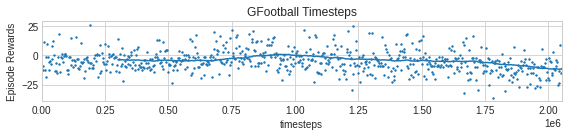

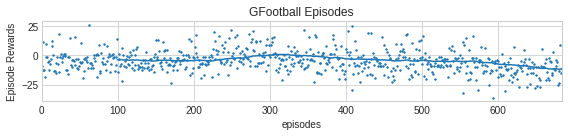

In [16]:
plt.style.use(['seaborn-whitegrid'])
total_timesteps = 2060000
results_plotter.plot_results([log_dir], total_timesteps, results_plotter.X_TIMESTEPS, "GFootball Timesteps")
results_plotter.plot_results([log_dir], total_timesteps, results_plotter.X_EPISODES, "GFootball Episodes")

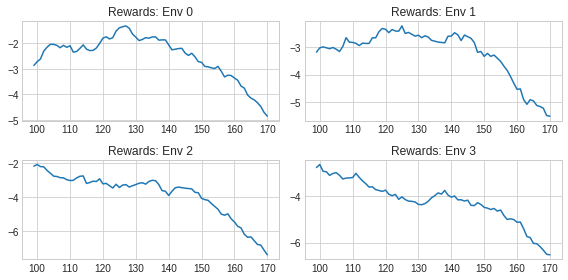

In [14]:
n_envs=4
plt.style.use(['seaborn-whitegrid'])
log_files = [os.path.join(log_dir, f"{i}.monitor.csv") for i in range(n_envs)]

nrows = np.ceil(n_envs/2)
fig = plt.figure(figsize=(8, 2 * nrows))
for i, log_file in enumerate(log_files):
    if os.path.isfile(log_file):
        df = pd.read_csv(log_file, skiprows=1)
        plt.subplot(nrows, 2, i+1, label=log_file)
        df['r'].rolling(window=100).mean().plot(title=f"Rewards: Env {i}")
        plt.tight_layout()
plt.show()